## Introduction

In this project, we will work with a dataset that captures **hourly energy consumption** over time. This dataset provides insights into the energy usage patterns, which can vary based on factors such as seasonality, time of day, and external influences (e.g., weather). Accurate predictions of energy consumption are essential for effective energy management, demand forecasting, and grid stability.

### Objective
The primary goal of this machine learning model is to **accurately predict hourly energy consumption**. By building a predictive model, we aim to forecast future energy demand based on historical patterns in the data. This can help utility providers, grid operators, and other stakeholders optimize resource allocation and manage supply more efficiently.

### Model Choice
We will use **XGBoost (Extreme Gradient Boosting)** for this prediction task. XGBoost is a popular machine learning algorithm known for its efficiency and performance, especially on structured or tabular data. Some reasons why XGBoost is well-suited for this project include:

- **High Accuracy**: XGBoost is often one of the top-performing algorithms for regression and classification tasks.
- **Handling of Missing Data**: XGBoost can handle missing values automatically, which is beneficial when working with real-world data.
- **Feature Engineering and Selection**: XGBoost can capture complex patterns in the data through gradient boosting, and it’s able to identify important features automatically.
- **Fast Execution**: XGBoost is optimized for speed, making it suitable for large datasets and computationally intensive tasks.

By leveraging XGBoost's capabilities, we hope to achieve high accuracy in predicting future hourly energy consumption, thereby enabling better planning and decision-making in energy management.

## Evaluation Metric: RMSE

To evaluate the accuracy of our machine learning model, we will use **Root Mean Squared Error (RMSE)** as the primary metric. RMSE is a commonly used measure for regression tasks that calculates the average magnitude of the error between the predicted and actual values. 

### Why RMSE?

RMSE is particularly well-suited for this project because it provides several key advantages:
- **Sensitivity to Large Errors**: RMSE squares each error term before averaging, which means larger errors have a more significant impact on the final score. This is useful in scenarios like energy consumption prediction, where large errors could lead to costly misallocations of resources.
- **Interpretability in the Original Units**: Since RMSE is in the same units as the target variable (in this case, energy consumption in megawatts or MW), it is easier to interpret. For example, an RMSE of 50 MW means that, on average, the model's predictions are off by 50 MW, making it more understandable for stakeholders.

### Formula

The formula for RMSE is as follows:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- **n** is the number of observations,
- **y<sub>i</sub>** is the actual energy consumption value,
- **y&#770;<sub>i</sub>** (ŷᵢ) is the predicted energy consumption value.


### Interpretation of RMSE in Our Project

A lower RMSE value indicates better model performance, as it means the model’s predictions are closer to the actual values. In this project, a low RMSE will imply that our model is effective at predicting hourly energy consumption, which can help with real-time resource management and efficient energy distribution.

By optimizing our model to minimize RMSE, we aim to improve its predictive accuracy and ensure it’s suitable for practical, real-world applications.


In [1]:
# Import libraries

import numpy as np            # For numerical operations and linear algebra, such as array and matrix manipulations
import pandas as pd           # For data processing, including data manipulation and reading/writing CSV files (e.g., pd.read_csv)
import optuna                 # For automated hyperparameter tuning, which optimizes model parameters to improve accuracy
import logging                # For controlling and managing log outputs, especially useful in suppressing or capturing log messages
import seaborn as sns         # For data visualization, particularly for creating aesthetically pleasing statistical graphics
import matplotlib.pyplot as plt  # For general-purpose plotting, allows for custom charts and visualizations

import xgboost as xgb         # XGBoost library, used for efficient gradient boosting, which is popular for structured/tabular data
from xgboost import plot_importance, plot_tree  # Additional XGBoost functions for visualizing feature importance and decision trees

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Performance metrics for model evaluation, particularly useful for regression tasks

# Set color palette and style for visualizations
color_pal = sns.color_palette()    # Define a color palette for consistent styling across plots
plt.style.use('fivethirtyeight')   # Set plot style to 'fivethirtyeight' for a clean and professional look


![Types of Time Series](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)


## Types of Time Series

* **Purely Random Error**
  - This type of time series has no recognizable pattern, trend, or seasonality. The values fluctuate randomly around a constant mean and are independent of time.
  - Since there is no underlying structure to capture or predict, attempting to model this type of time series is typically futile. Such data might represent purely random noise or independent, identically distributed (i.i.d.) random values.
  - **Example**: Measurement errors in an experiment, where the values fluctuate randomly without any discernible trend.

* **Curvilinear Trend**
  - A curvilinear trend is a non-linear trend that increases or decreases at a varying rate over time. It can follow patterns like quadratic (parabolic) or exponential curves.
  - Quadratic trends form a U-shaped or inverted-U pattern, while exponential trends show rapid growth or decay.
  - This type of trend often indicates compounding growth or decay in the data, where values change at an accelerating rate.
  - **Example**: Population growth over time, which often follows an exponential trend as the population grows faster with each generation.

* **Increasing Linear Trend**
  - An increasing linear trend is a straight-line pattern showing a consistent upward movement in the data over time.
  - This trend suggests a steady rate of change and can often be observed in data where growth or increase happens at a constant rate.
  - Such trends are relatively easy to model and predict since they are based on a simple, consistent upward slope.
  - **Example**: Annual revenue growth of a business that is increasing at a constant rate over time.

* **Seasonal Pattern**
  - A seasonal pattern is a repeating fluctuation in data that occurs at regular intervals, often driven by time-based factors like seasons, months, weeks, or days.
  - Seasonal patterns are common in time series data influenced by recurring events (e.g., holidays or weather changes) that impact behavior cyclically.
  - This pattern typically has a fixed period, such as a weekly, monthly, or yearly cycle, and is characterized by predictable highs and lows within each period.
  - **Example**: Retail sales peaking during the holiday season and dipping in the off-season, reflecting a seasonal shopping pattern.

* **Seasonal Pattern with Linear Growth**
  - This type of time series combines both a seasonal pattern and a linear trend. It shows regular seasonal fluctuations superimposed on a steady upward or downward linear trend.
  - Over time, the seasonal highs and lows may increase or decrease in amplitude as the overall trend grows or declines linearly.
  - This pattern is common in industries where there is both an overall growth trend and seasonal fluctuations affecting demand or behavior.
  - **Example**: Monthly electricity consumption in a growing city, where there is increased usage during summer and winter (seasonal pattern), but with a general upward trend as the population grows over the years.


In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

In [3]:
# Load head data
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
# Load tail data
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


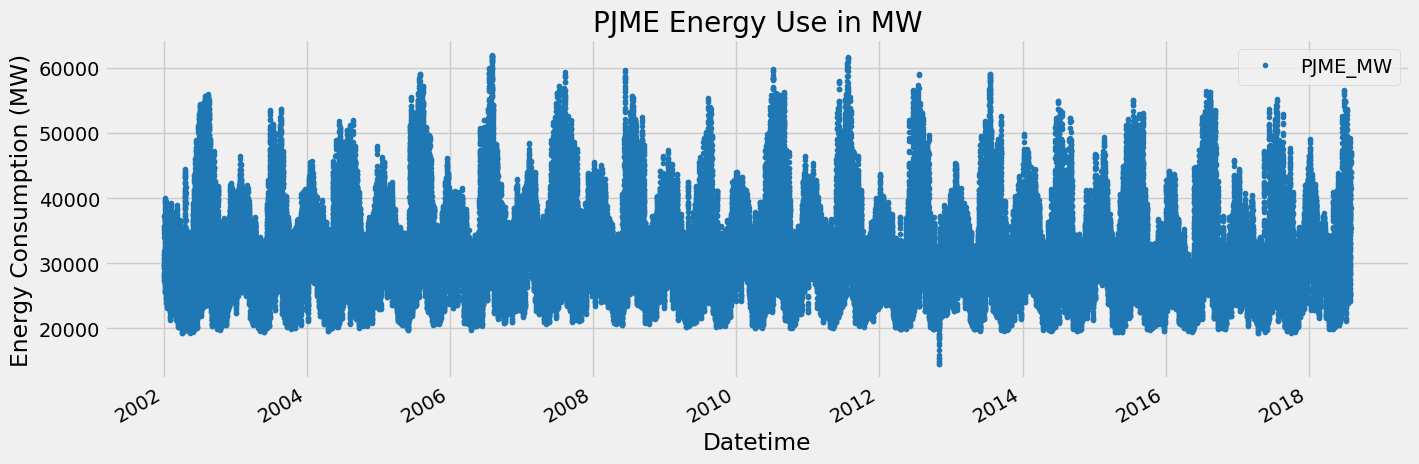

In [5]:
# Plotting the PJME energy use data with specific styling options
ax = df.plot(
    style=".",                    # Use dots to represent each data point on the plot
    figsize=(15, 5),              # Set the figure size to 15 inches wide by 5 inches tall
    color=color_pal[0],           # Use the first color from the color palette for the plot points
    title="PJME Energy Use in MW" # Set the title of the plot to indicate the data being displayed
)

# Add axis labels
ax.set_xlabel("Datetime")
ax.set_ylabel("Energy Consumption (MW)")

# Display the plot
plt.show()


## Train / Test Split

To effectively evaluate our model’s performance, we will split our dataset into two main parts:
1. **Training Set**: Used to train the machine learning model.
2. **Testing Set**: Used to evaluate the model’s performance on unseen data.

However, to fine-tune our model and assess its ability to generalize well, we will further split the **training set** into two subsets:
- **Train Set**: Used for training the model, where the model learns from the data patterns and relationships.
- **Validation Set**: Used to tune the model and prevent overfitting, allowing us to evaluate the model’s performance on data it hasn’t seen during training but is still part of the training process.

### Why Do We Need a Train / Validation / Test Split?

When developing a machine learning model, it’s crucial to ensure that the model performs well not only on the data it was trained on but also on new, unseen data. This requires careful evaluation to avoid common pitfalls, such as **overfitting** (when the model performs well on the training data but poorly on new data).

1. **Training Set**:
   - The model uses this subset to learn patterns, relationships, and other relevant characteristics of the data.
   - By training on this set, the model develops the parameters (e.g., weights in a neural network) necessary to make predictions.

2. **Validation Set**:
   - This subset helps us fine-tune model hyperparameters (e.g., learning rate, regularization parameters) and make decisions about the model architecture.
   - By evaluating the model on the validation set, we get an idea of its performance on data it hasn’t been trained on, helping to prevent overfitting.
   - The validation set is especially useful when performing techniques like **cross-validation** or **hyperparameter tuning** to find the best model configuration.

3. **Testing Set**:
   - After finalizing the model and tuning its parameters, we use the testing set to evaluate its true generalization ability.
   - The testing set provides an unbiased assessment of the model’s performance on completely unseen data, simulating how it would perform in a real-world setting.
   - This step is crucial to verify that the model’s performance is not overly optimistic and is stable across new data.

### Example of Train / Validation / Test Split

In a typical time series analysis or machine learning project, we may split the data as follows:
- **70% Training Set**: Used to train the model.
- **15% Validation Set**: Used to tune the model and prevent overfitting.
- **15% Testing Set**: Used to assess the final model performance.


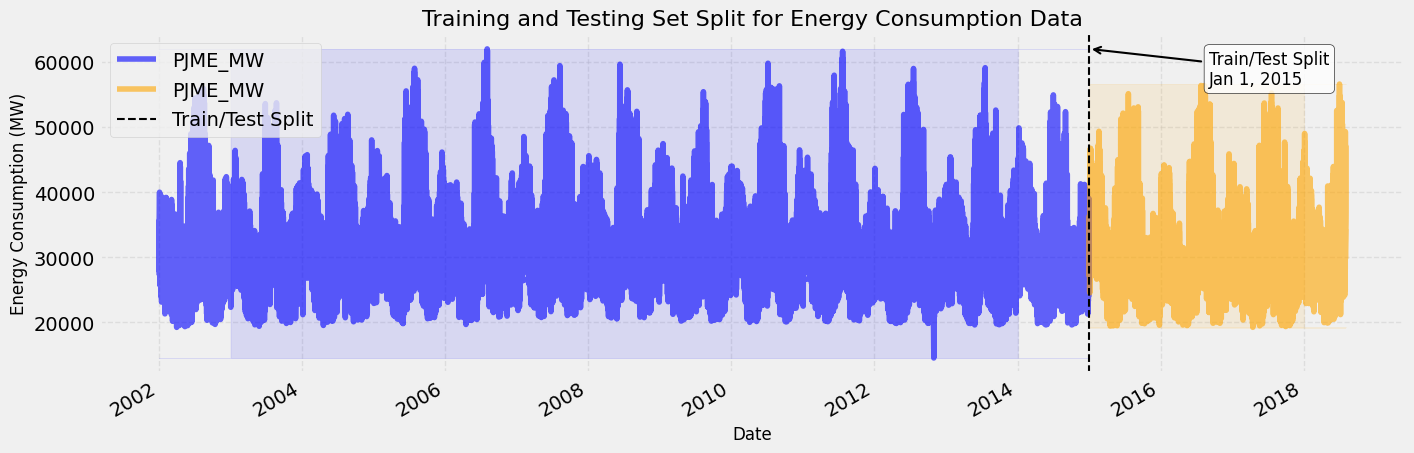

In [6]:
# Splitting the dataset into training and testing sets based on a date condition
# The training set includes data before January 1, 2015
# The testing set includes data from January 1, 2015, onwards

train = df.loc[df.index < "2015-01-01"]  # Define the training set with data before 1st Jan 2015
test = df.loc[df.index >= "2015-01-01"]  # Define the testing set with data from 1st Jan 2015 onwards

# Create a plot to visualize the split between training and testing sets
fig, ax = plt.subplots(figsize=(15, 5))  # Set up the figure and axes with a specified size

# Plot the training set
train.plot(ax=ax, label="Training Set", color="blue", alpha=0.6)

# Plot the testing set
test.plot(ax=ax, label="Testing Set", color="orange", alpha=0.6)

# Add a vertical line to indicate the split date between training and testing sets
split_date = "2015-01-01"
ax.axvline(split_date, color="black", linestyle="--", linewidth=1.5, label="Train/Test Split")

# Shade the training and testing areas for better distinction
ax.fill_between(train.index, train.min().min(), train.max().max(), color="blue", alpha=0.1)
ax.fill_between(test.index, test.min().min(), test.max().max(), color="orange", alpha=0.1)

# Add a title and labels
ax.set_title("Training and Testing Set Split for Energy Consumption Data", fontsize=16)
ax.set_xlabel("Date", fontsize=12)  # X-axis label
ax.set_ylabel("Energy Consumption (MW)", fontsize=12)  # Y-axis label

# Enable grid for better readability
ax.grid(True, linestyle="--", alpha=0.5)

# Add legend to clarify different parts of the data
ax.legend(loc="upper left")

# Add annotation to indicate split date
ax.annotate(
    "Train/Test Split\nJan 1, 2015", 
    xy=(split_date, train.max().max()), 
    xycoords='data',
    xytext=(0.85, 0.85), 
    textcoords='axes fraction',
    arrowprops=dict(arrowstyle="->", color="black", lw=1.5),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
)

# Display the plot
plt.show()


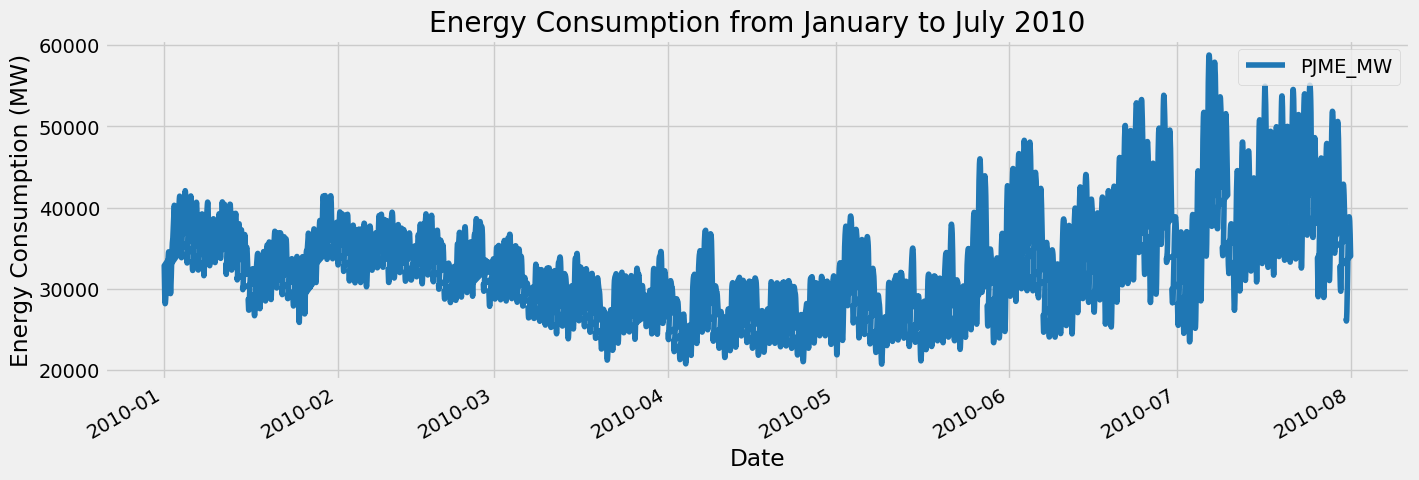

In [7]:
# Filter the DataFrame based on the date range
filtered_df = df.loc[(df.index > "2010-01-01") & (df.index < "2010-08-01")]

# Apply a 7-day rolling average to smooth the data
smoothed_df = filtered_df.rolling(window=7, center=True).mean()

# Plot the smoothed data
ax = smoothed_df.plot(figsize=(15, 5), title="Energy Consumption from January to July 2010", color=color_pal[0])

# Add additional plot information for clarity
ax.set_xlabel("Date")  # X-axis label
ax.set_ylabel("Energy Consumption (MW)")  # Y-axis label
ax.grid(True)  # Enable grid for better readability

# Add legend if there are multiple columns
if len(smoothed_df.columns) > 1:
    ax.legend(title="Metrics")

plt.show()


## Explanation of `create_features` Function

The `create_features` function enriches the dataset by extracting various time-based features from the datetime index of a DataFrame. These features help capture temporal patterns and seasonality in time series data, which can improve the performance of machine learning models for tasks like forecasting. Here’s a breakdown of each set of features created in the function:

### Basic Temporal Features
1. **Hour** (`df["hour"]`): Extracts the hour (0–23) from the datetime index. This feature is useful for identifying hourly patterns, such as peak and off-peak usage in energy consumption.
   
2. **Day of the Week** (`df["dayofweek"]`): Extracts the day of the week (0 for Monday to 6 for Sunday). This can capture weekly patterns, such as increased activity on weekends.

3. **Quarter** (`df["quarter"]`): Extracts the quarter of the year (1–4). This feature is beneficial when there are quarterly cycles or seasonal effects.

4. **Month** (`df["month"]`): Extracts the month (1–12), which can help capture monthly seasonality, such as higher energy use in winter or summer.

5. **Year** (`df["year"]`): Extracts the year, which is useful if there are long-term trends over multiple years.

6. **Day of the Year** (`df["dayofyear"]`): Extracts the day of the year (1–365 or 366 for leap years). This feature helps capture annual seasonality or trends.

### Additional Temporal Features
7. **Day of the Month** (`df["dayofmonth"]`): Extracts the day of the month (1–31), which can be helpful for monthly billing cycles or specific dates that impact activity.

8. **Week of the Year** (`df["weekofyear"]`): Extracts the ISO week number (1–52) of the year. This feature helps capture trends or seasonality at a weekly level.

9. **Is Weekend** (`df["is_weekend"]`): A binary feature that indicates if the day is a weekend (1 if Saturday or Sunday, otherwise 0). This is useful for distinguishing between weekday and weekend patterns.

10. **Is Month Start / End** (`df["is_month_start"]`, `df["is_month_end"]`): Binary features that indicate the start and end of a month. These are useful when activity spikes at the beginning or end of each month.

11. **Is Quarter Start / End** (`df["is_quarter_start"]`, `df["is_quarter_end"]`): Binary features that indicate the start and end of a quarter. Useful for quarterly patterns, such as business cycles.

12. **Is Year Start / End** (`df["is_year_start"]`, `df["is_year_end"]`): Binary features for the start and end of the year. These can capture changes in behavior that happen around the beginning or end of each year.

### Cyclical Features (Sine and Cosine Transformations)
Time-based features like `hour`, `day of the week`, and `month` have cyclical nature (e.g., after 23:00 comes 00:00). Using sine and cosine transformations allows machine learning models to recognize these cyclical patterns.

13. **Sine and Cosine of Hour** (`sin_hour`, `cos_hour`): These transformations capture the cyclical nature of hours (e.g., 23:00 to 00:00).

14. **Sine and Cosine of Day of the Week** (`sin_dayofweek`, `cos_dayofweek`): These transformations allow models to understand the cyclical nature of days in a week (e.g., Sunday to Monday).

15. **Sine and Cosine of Month** (`sin_month`, `cos_month`): These transformations capture the cyclical pattern of months (e.g., December to January).

### Purpose and Usefulness
Adding these features allows models to recognize patterns that repeat on a daily, weekly, monthly, or yearly basis, and it can improve the predictive power for time series data. For instance:
- **Cyclical transformations** allow models to interpret continuous cycles more effectively.
- **Binary indicators** for the start/end of months, quarters, and years provide insight into behavioral shifts that occur around these boundaries.
- **Hour and day of the week** features help capture daily and weekly seasonality, common in many time series data types.

This feature engineering approach can be especially valuable in forecasting tasks, where understanding the temporal structure of data is key to creating an effective predictive model.


In [8]:
def create_features(df):
    # Existing features
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    
    # Additional features
    df["dayofmonth"] = df.index.day              # Day of the month (1 to 31)
    df["weekofyear"] = df.index.isocalendar().week  # Week of the year (1 to 52)
    df["is_weekend"] = df.index.dayofweek >= 5    # Binary feature for weekends (1 if weekend, else 0)
    df["is_month_start"] = df.index.is_month_start # Binary feature for start of month
    df["is_month_end"] = df.index.is_month_end     # Binary feature for end of month
    df["is_quarter_start"] = df.index.is_quarter_start # Binary feature for start of quarter
    df["is_quarter_end"] = df.index.is_quarter_end     # Binary feature for end of quarter
    df["is_year_start"] = df.index.is_year_start   # Binary feature for start of year
    df["is_year_end"] = df.index.is_year_end       # Binary feature for end of year

    # Cyclical features (useful for capturing seasonality patterns)
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)    # Sine transformation for hour
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)    # Cosine transformation for hour
    df["sin_dayofweek"] = np.sin(2 * np.pi * df["dayofweek"] / 7)  # Sine transformation for day of the week
    df["cos_dayofweek"] = np.cos(2 * np.pi * df["dayofweek"] / 7)  # Cosine transformation for day of the week
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)  # Sine transformation for month
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)  # Cosine transformation for month
    
    return df

df = create_features(df)


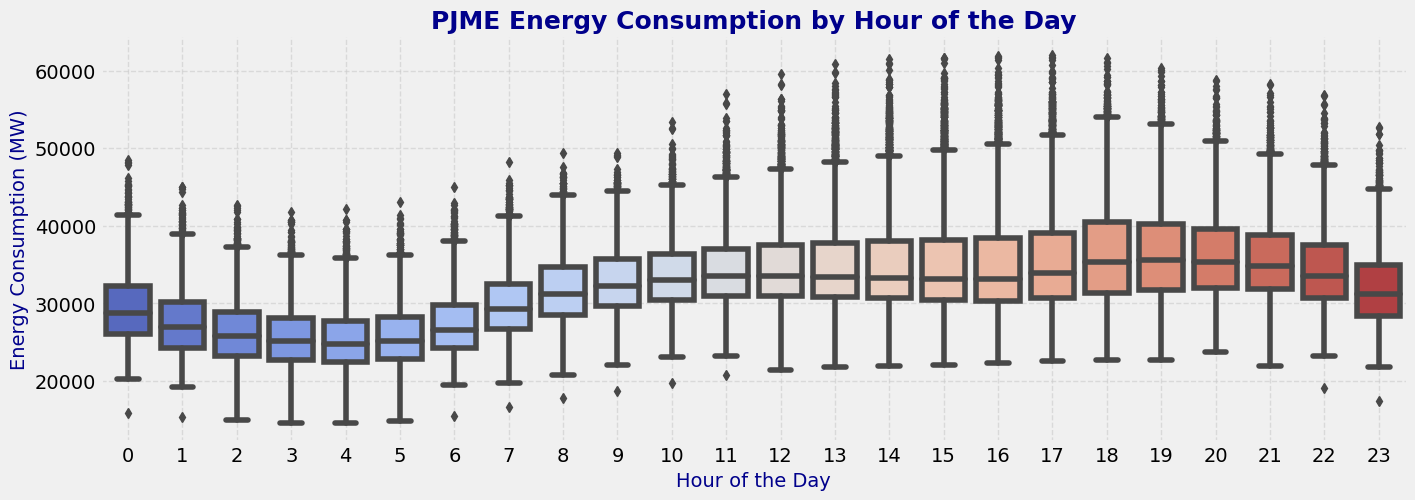

In [9]:
# Set a larger figure size and style
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_style("whitegrid")  # Set the background style to whitegrid for a cleaner look

# Use a color palette for the boxplot
sns.boxplot(data=df, x="hour", y="PJME_MW", ax=ax, palette="coolwarm")  # Adjust color with a palette

# Add a title and style it
ax.set_title("PJME Energy Consumption by Hour of the Day", fontsize=18, fontweight="bold", color="darkblue")

# Customize the x and y axis labels
ax.set_xlabel("Hour of the Day", fontsize=14, color="darkblue")
ax.set_ylabel("Energy Consumption (MW)", fontsize=14, color="darkblue")

# Add gridlines for better readability
ax.grid(True, linestyle="--", alpha=0.6)

# Remove the top and right spines to give the plot a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.show()


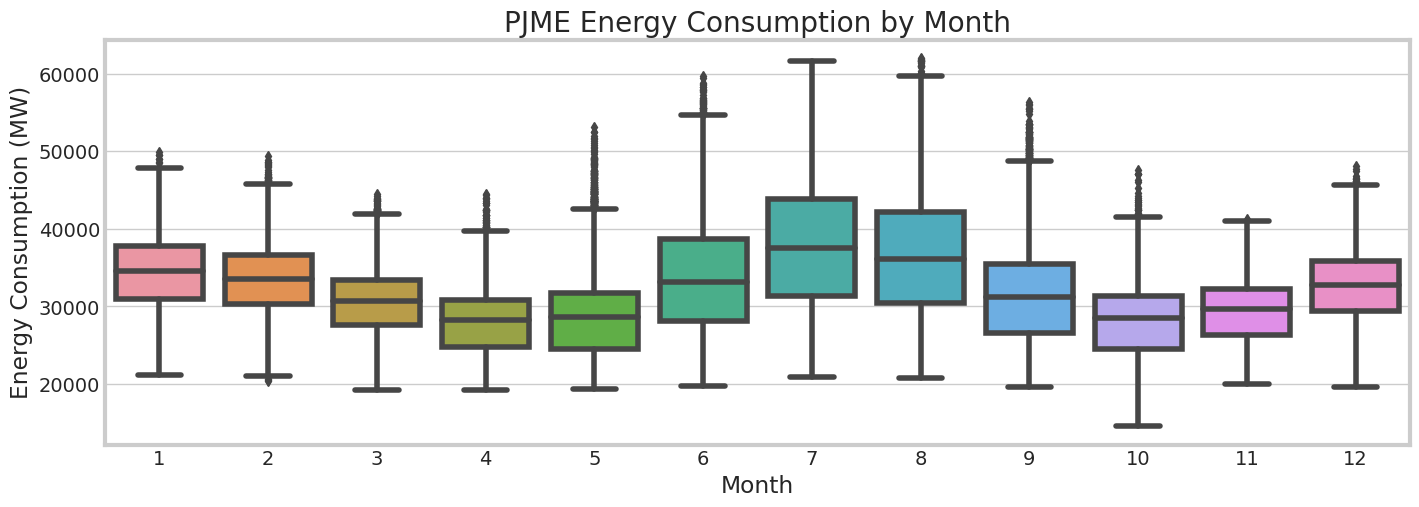

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))  # Use plt.subplots instead of plt.subplot
sns.boxplot(data=df, x="month", y="PJME_MW", ax=ax)  # Pass ax to sns.boxplot
ax.set_title("PJME Energy Consumption by Month")
ax.set_xlabel("Month")  # Optional: Label the x-axis
ax.set_ylabel("Energy Consumption (MW)")  # Optional: Label the y-axis
plt.show()


## Detailed Explanation of Each Step in the Model Structure (Excluding Feature Engineering and Defining Features)

The model structure is carefully designed to achieve accurate predictions by optimizing and evaluating the model in a systematic way. Each step in this process contributes to building a robust model capable of generalizing to unseen data. Here’s why each remaining step is essential:

---

### 1. Hyperparameter Tuning with Optuna

Hyperparameter tuning is a critical step that optimizes the model’s configuration to improve predictive performance. Hyperparameters, such as learning rate, max depth, and regularization parameters, control how the model learns and directly impact its accuracy and generalization capabilities. Optuna is used here for efficient and automated hyperparameter tuning for several reasons:
- **Automated Optimization**: Optuna automates the process of searching for the best combination of hyperparameters, eliminating the need for manual tuning, which can be labor-intensive and error-prone.
- **Adaptive Search**: Optuna’s trial-based approach learns from previous trials to explore the hyperparameter space more efficiently, focusing on promising configurations.
- **Objective-Based**: The tuning process is guided by a clear objective, minimizing Root Mean Squared Error (RMSE), ensuring that each hyperparameter combination tested is aligned with the goal of improving model accuracy.

By optimizing hyperparameters, we ensure that the model is well-suited to the data, avoiding configurations that might cause underfitting or overfitting. This results in a model with better accuracy and the ability to generalize to new data.

### 2. Early Stopping

Early stopping is a technique used during training to prevent the model from overfitting the training data. It monitors the model’s performance on a validation set and halts training when no improvement is observed for a specified number of rounds. This is crucial for several reasons:
- **Prevents Overfitting**: Early stopping prevents the model from becoming too complex by stopping training as soon as it starts overfitting the training data.
- **Efficient Training**: By halting the training process once improvement stalls, early stopping reduces computational costs and training time.
- **Ensures Generalization**: By monitoring performance on a validation set, early stopping ensures the model is not just memorizing the training data but is also likely to perform well on unseen data.

Early stopping strikes a balance between underfitting and overfitting, resulting in a model that is both accurate and efficient.

### 3. Training the Final Model

After finding the best hyperparameters, the model is retrained on the entire training set using these optimized settings. This step is essential because:
- **Utilizes Optimal Configuration**: Training with the best hyperparameters found by Optuna ensures the model’s learning process is tuned for maximum performance.
- **Leverages Full Training Data**: Using the entire training set allows the model to capture as many patterns as possible, increasing its ability to generalize.
- **Configures for Real-World Use**: A model trained with optimized parameters and early stopping is well-prepared for deployment, as it has been fine-tuned to handle the complexities of real-world data.

Training the final model with optimal settings on all available data maximizes its predictive capabilities.

### 4. Model Evaluation

Model evaluation is conducted on a separate test set to assess the model's performance on unseen data. We use Root Mean Squared Error (RMSE) as the evaluation metric:
- **Measures Prediction Accuracy**: RMSE provides a measure of the average prediction error, helping quantify how closely the model’s predictions match actual values.
- **Penalizes Large Errors**: By squaring errors before averaging, RMSE penalizes larger errors more heavily, which is important in applications where significant deviations can be costly.
- **Unbiased Assessment**: Evaluating on a test set (which was not seen during training or tuning) provides an unbiased measure of the model’s performance and ensures that the reported accuracy reflects real-world scenarios.

RMSE on the test set serves as a reliable metric for understanding the model’s ability to generalize beyond the training data.

### 5. Feature Importance Analysis

Feature importance analysis identifies which features contributed most to the model’s predictions. Understanding feature importance is valuable for several reasons:
- **Interpretability**: Knowing which features impact predictions the most makes the model’s decisions easier to understand and interpret, which is critical in applications like energy forecasting.
- **Data Insights**: Feature importance reveals patterns and relationships within the data, providing domain experts with insights into the factors that drive energy consumption.
- **Guides Future Improvements**: By understanding which features are impactful, we can focus future efforts on refining or expanding those features, leading to even better model performance.

Feature importance analysis not only adds interpretability to the model but also offers a foundation for future model improvements.

---

## Summary

This structured approach maximizes the model’s accuracy, efficiency, and interpretability. By systematically tuning, training, evaluating, and interpreting the model, we create a robust forecasting model that can handle real-world complexities and provide valuable insights.

- **Hyperparameter Tuning**: Optimizes model configuration for better performance and generalization.
- **Early Stopping**: Prevents overfitting and ensures efficient training.
- **Final Training**: Leverages the best parameters and full training data for maximum predictive power.
- **Model Evaluation**: Provides an unbiased assessment of the model’s generalizability using RMSE.
- **Feature Importance Analysis**: Offers interpretability and insights into key drivers of the target variable.

This structured methodology ensures a reliable and high-performing model that can make accurate predictions and offer insights into the underlying data patterns.


In [11]:
# Apply feature engineering to train and test sets
train = create_features(train)
test = create_features(test)

# Define features and target
TARGET = "PJME_MW"
FEATURES = [
    "hour", "dayofweek", "quarter", "month", "year", "dayofyear",
    "dayofmonth", "weekofyear", "is_weekend", "is_month_start",
    "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start",
    "is_year_end", "sin_hour", "cos_hour", "sin_dayofweek", "cos_dayofweek",
    "sin_month", "cos_month"
]

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


Test RMSE: 3655.149804261552


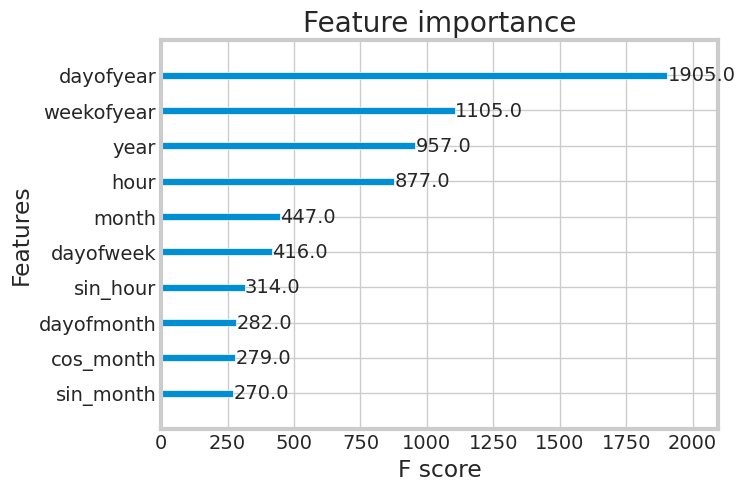

In [12]:
# Suppress Optuna's output by setting the logging level to WARNING
optuna.logging.set_verbosity(logging.WARNING)

# Optuna objective function for hyperparameter tuning
def objective(trial):
    """
    Defines the objective function for Optuna hyperparameter tuning of the XGBRegressor model.

    Parameters:
    - trial: An Optuna Trial object which suggests values for the hyperparameters.

    Returns:
    - rmse: The Root Mean Squared Error (RMSE) on the test set, used as the objective to minimize.
    """
    
    # Define the hyperparameters with search spaces for Optuna to optimize
    param = {
        "n_estimators": 1000,  # Set a high number of estimators, allowing early stopping to determine optimal rounds
        "early_stopping_rounds": 50,  # Stops training if there's no improvement for 50 rounds
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),  # Controls step size, log scale
        "max_depth": trial.suggest_int("max_depth", 3, 10),  # Limits tree depth to control complexity
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Minimum sum of weights in a child node
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of data for each tree to avoid overfitting
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features per tree
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),  # Minimum loss reduction for split, log scale
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),  # L2 regularization, log scale
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),  # L1 regularization, log scale
        "eval_metric": "rmse"  # Evaluation metric set to RMSE (Root Mean Squared Error)
    }
    
    # Initialize the XGBRegressor model with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)
    
    # Fit the model on the training set, with the validation set for early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Use test set as a validation set for early stopping
        verbose=False  # Suppress output to keep the output clean
    )
    
    # Predict on the test set and calculate RMSE as the objective value
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # Calculate RMSE to evaluate model performance
    
    return rmse  # Return RMSE as the value to be minimized by Optuna

# Run Optuna optimization
study = optuna.create_study(direction="minimize")  # Create an Optuna study to minimize RMSE
study.optimize(objective, n_trials=50)  # Run 50 trials of hyperparameter optimization

# Train final model with best parameters
# Retrieve the best parameters found by Optuna and set additional fixed parameters
best_params = study.best_params
best_params["n_estimators"] = 1000
best_params["early_stopping_rounds"] = 50
best_params["eval_metric"] = "rmse"

# Initialize and train the final model using the best-found hyperparameters
model = xgb.XGBRegressor(**best_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Use the test set as a validation set for early stopping
    verbose=False  # Suppress output for a clean log
)

# Evaluate the model
# Generate predictions on the test set and calculate the RMSE to assess performance
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Test RMSE:", rmse)  # Print the final RMSE on the test set

# Plot feature importance
# Visualize the top 10 most important features to understand which features contributed most to the model's predictions
xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.show()


## Explanation of the Code

The provided code accomplishes three main tasks:

1. **Make Predictions and Combine Data**:
   - The code first makes predictions on the test set using the trained model. These predictions are stored in a new column, `MW_Prediction`, within the `test` DataFrame.
   - It then combines the `train` and `test` DataFrames (with `MW_Prediction` included) into a single DataFrame called `pjme_all`. This allows for seamless plotting of both training and test data, along with the predictions, across the full time period.

2. **Plot Actual vs. Predicted Energy Consumption with Various Visual Styles**:
   - The code includes several variations for plotting actual (`PJME_MW`) and predicted (`MW_Prediction`) energy consumption values:
     - **Line and Point Combination**: In the first plot, actual values are shown as a solid line, and predicted values as a dashed line, to distinguish them visually.
     - **Point-Only Styles**: Subsequent plots use point-only styles, where both actual and predicted values are represented by dots (no connecting lines) for different periods. The colors and marker sizes are customized to enhance visibility.
   - Each plot focuses on specific date ranges, allowing for detailed comparisons between actual and predicted values over smaller time periods, such as January 2015 or the first week of July 2015.

3. **Enhanced Plot Customization**:
   - Each plot includes additional elements:
     - **Labels and Titles**: Custom labels, titles, and legends for clarity and interpretation.
     - **Gridlines**: Added for readability.
     - **Highlighting and Annotations**: Specific date ranges are highlighted, and peak values are annotated to mark significant points.

## Analysis of Results

1. **Prediction Accuracy Over Time**:
   - By plotting actual vs. predicted values for both broader (e.g., January 2015) and narrower (e.g., July 1–7, 2015) time periods, we can assess the model’s prediction accuracy at different time scales. 
   - The plots suggest that the model captures general trends but may struggle with day-to-day fluctuations or sharp changes, as seen in the variations between the points.

2. **Visual Representation of Model Performance**:
   - **Line and Dot Comparison**: The line-and-dot combination plot gives an overview of trends, but the point-only plots allow for a more granular, day-by-day analysis, helping identify where the model deviates from the actual values.
   - **Highlighting Specific Dates**: By narrowing the view to specific periods, such as the first week of January and July, we can observe the model's behavior during periods with potentially different consumption patterns (e.g., holidays, weekends, weekdays).

3. **Potential Areas for Improvement**:
   - The model seems to miss specific spikes and dips in consumption. This could indicate that additional features (e.g., holiday indicators, weather conditions) or advanced modeling techniques might help capture these variations more accurately.

Overall, the code provides a comprehensive approach for visualizing and analyzing the accuracy of energy consumption predictions, identifying areas where the model performs well and where it could be improved. The visualizations are especially helpful for understanding temporal patterns and identifying potential causes of forecast errors.


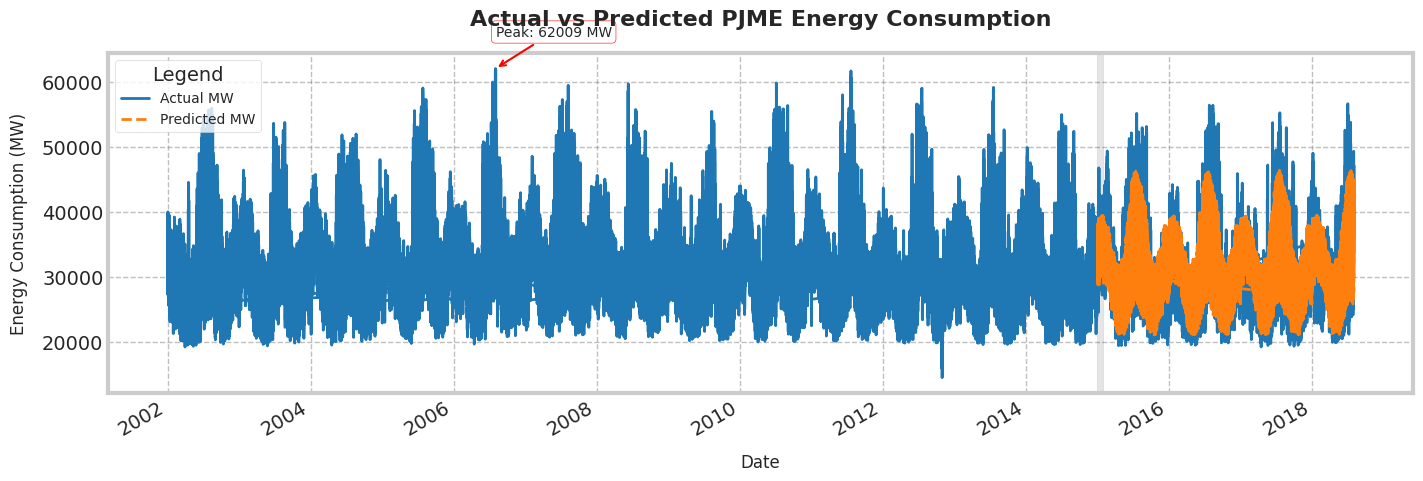

In [13]:
# Make predictions on the test set and add them as a new column in test
test['MW_Prediction'] = model.predict(X_test)  # Assuming 'model' is your trained model

# Concatenate the test set with predictions and the training set
pjme_all = pd.concat([train, test], sort=False)

# Plot the actual vs. predicted energy consumption with improved styling
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the actual values with a solid line
pjme_all['PJME_MW'].plot(ax=ax, color='#1f77b4', linewidth=2, label='Actual MW')

# Plot the predicted values with a dashed line for distinction
pjme_all['MW_Prediction'].plot(ax=ax, color='#ff7f0e', linestyle='--', linewidth=2, label='Predicted MW')

# Customize x and y labels
ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12, labelpad=10)

# Set a title with larger font and padding
ax.set_title("Actual vs Predicted PJME Energy Consumption", fontsize=16, fontweight='bold', pad=20)

# Adjust the legend for clarity
ax.legend(loc="upper left", fontsize=10, frameon=True, title="Legend")

# Enable grid with light color for readability
ax.grid(True, linestyle='--', color='grey', alpha=0.5)

# Highlight a specific period, if needed (optional)
highlight_start, highlight_end = "2015-01-01", "2015-02-01"
ax.axvspan(highlight_start, highlight_end, color="black", alpha=0.1, label="Highlighted Period")

# Add annotations for peak or significant points (optional)
peak_date = pjme_all['PJME_MW'].idxmax()  # Find date of max energy usage
peak_value = pjme_all['PJME_MW'].max()    # Find max energy usage value
ax.annotate(
    f"Peak: {int(peak_value)} MW", 
    xy=(peak_date, peak_value), 
    xycoords="data",
    xytext=(peak_date, peak_value + 5000),  # Adjust annotation position
    arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.8)
)

# Show the plot
plt.show()


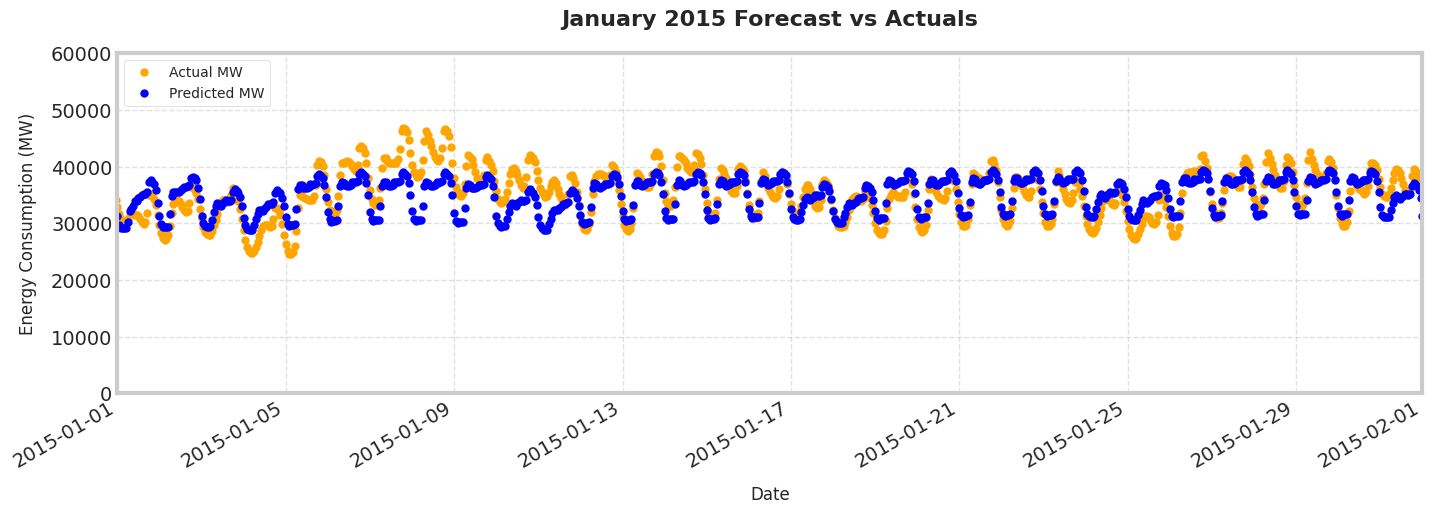

In [14]:
# Plot the forecast with the actuals, both as points
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual values as orange points
pjme_all['PJME_MW'].plot(
    ax=ax,
    color='orange',        # Color for actual values (orange)
    linestyle='',          # No line connecting points
    marker='o',            # Use dots for actual values
    markersize=5,
    label='Actual MW'
)

# Plot predicted values as blue points
pjme_all['MW_Prediction'].plot(
    ax=ax,
    color='blue',          # Color for predicted values (blue)
    linestyle='',          # No line connecting points
    marker='o',            # Use dots for predicted values
    markersize=5,
    label='Predicted MW'
)

# Set x-axis limits to focus on January 2015
ax.set_xbound(lower='2015-01-01', upper='2015-02-01')

# Set y-axis limits for better scaling
ax.set_ylim(0, 60000)

# Add labels and title
ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12, labelpad=10)
ax.set_title("January 2015 Forecast vs Actuals", fontsize=16, fontweight='bold', pad=20)

# Add a legend with custom titles
ax.legend(loc="upper left", frameon=True, fontsize=10)

# Enable grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


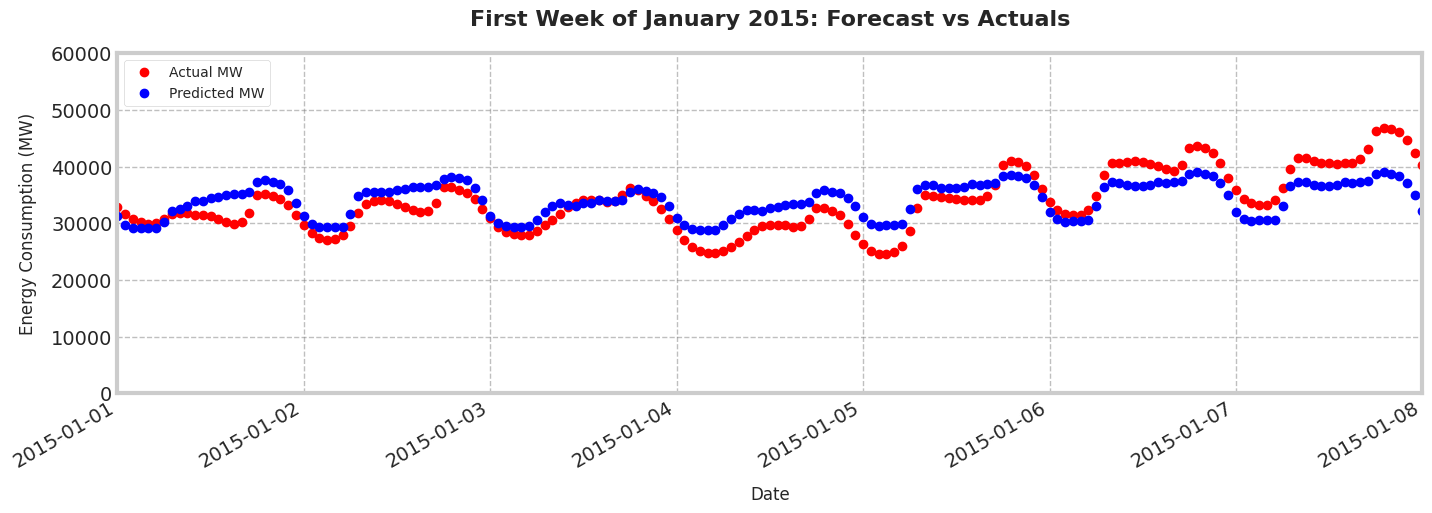

In [15]:
# Plot the forecast with the actuals as points
fig, ax = plt.subplots(figsize=(15, 5))  # Set figure size directly in subplots

# Plot actual values as red points
pjme_all['PJME_MW'].plot(
    ax=ax,
    color='red',               # Color for actual values (red)
    linestyle='',              # No line connecting points
    marker='o',                # Use dots for actual values
    markersize=6,              # Size of the markers for actual values
    label='Actual MW'
)

# Plot predicted values as blue points
pjme_all['MW_Prediction'].plot(
    ax=ax,
    color='blue',              # Color for predicted values (blue)
    linestyle='',              # No line connecting points
    marker='o',                # Use dots for predicted values
    markersize=6,              # Size of the markers for predicted values
    label='Predicted MW'
)

# Set x-axis and y-axis limits for focusing on the first week of January 2015
ax.set_xbound(lower='2015-01-01', upper='2015-01-08')
ax.set_ylim(0, 60000)

# Add labels and title with customized fonts and padding
ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12, labelpad=10)
ax.set_title("First Week of January 2015: Forecast vs Actuals", fontsize=16, fontweight='bold', pad=20)

# Customize the legend for clarity
ax.legend(loc="upper left", frameon=True, fontsize=10)

# Enable grid lines for readability, with a lighter color and dashed style
ax.grid(True, linestyle='--', color='grey', alpha=0.5)

# Display the plot
plt.show()


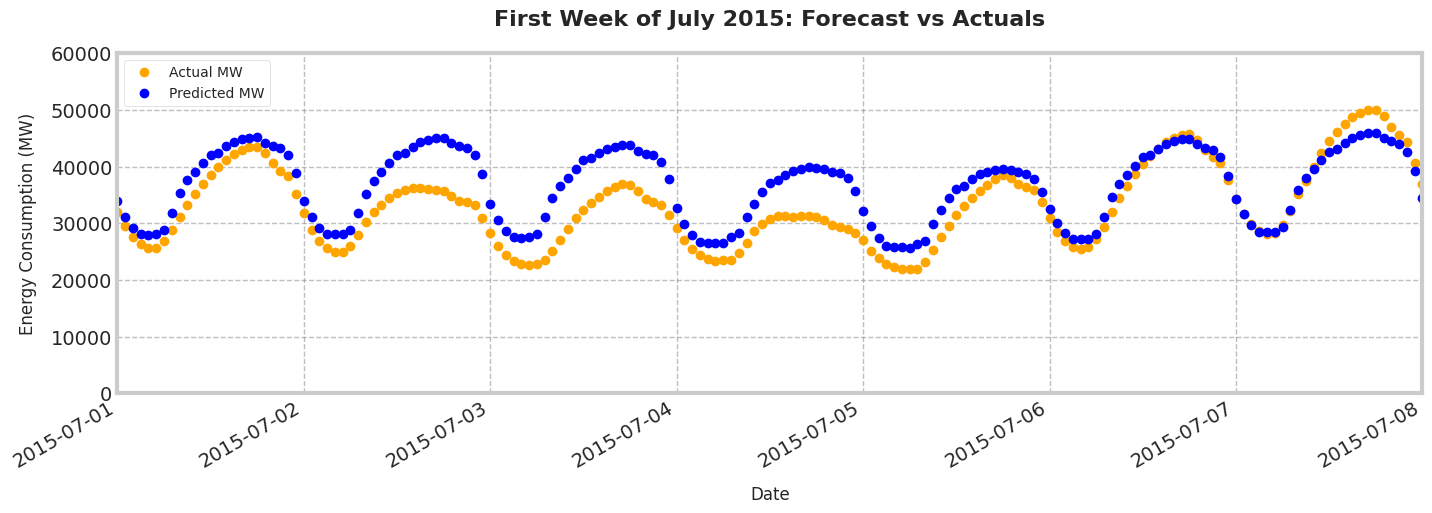

In [16]:
# Create the plot with specified figure size
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual values as orange points
pjme_all['PJME_MW'].plot(
    ax=ax,
    color='orange',             # Orange color for actual values
    linestyle='',               # No line connecting points for actual values
    marker='o',                 # Dots for actual values
    markersize=6,               # Size of markers
    label='Actual MW'
)

# Plot predicted values as blue points
pjme_all['MW_Prediction'].plot(
    ax=ax,
    color='blue',               # Blue color for predicted values
    linestyle='',               # No line connecting points for predicted values
    marker='o',                 # Dots for predicted values
    markersize=6,               # Size of markers
    label='Predicted MW'
)

# Set x-axis and y-axis limits to focus on the specified date range
ax.set_xbound(lower='2015-07-01', upper='2015-07-08')
ax.set_ylim(0, 60000)

# Add labels and title with customized fonts and padding
ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Energy Consumption (MW)", fontsize=12, labelpad=10)
ax.set_title("First Week of July 2015: Forecast vs Actuals", fontsize=16, fontweight='bold', pad=20)

# Customize the legend for clarity
ax.legend(loc="upper left", frameon=True, fontsize=10)

# Enable grid lines for readability, with a lighter color and dashed style
ax.grid(True, linestyle='--', color='grey', alpha=0.5)

# Display the plot
plt.show()


## Explanation of Error Metrics Results

In this notebook cell, we calculate three error metrics to evaluate the performance of our energy consumption forecasting model:

1. **Root Mean Squared Error (RMSE)**:
   - **Value**: 3655.28
   - **Interpretation**: RMSE measures the average magnitude of the error in the same units as the target variable (MW in this case). It is particularly sensitive to large errors due to the squaring of each error term before averaging. A lower RMSE indicates better predictive performance. Here, an RMSE of 3655.28 suggests that, on average, the model’s predictions deviate from the actual values by approximately 3655 MW.

2. **Mean Absolute Error (MAE)**:
   - **Value**: 2846.45
   - **Interpretation**: MAE represents the average absolute difference between predicted and actual values. It is less sensitive to outliers compared to RMSE, as it does not square the errors. An MAE of 2846.45 MW implies that the model's predictions are, on average, off by around 2846 MW from the actual consumption values.

3. **Mean Absolute Percentage Error (MAPE)**:
   - **Value**: 9.04%
   - **Interpretation**: MAPE is a percentage-based metric that provides an easy-to-understand measure of prediction accuracy in relative terms. It indicates the average percentage error across all predictions. A MAPE of 9.04% means that, on average, the model's predictions are 9.04% off from the actual values. This is particularly useful for understanding the model’s performance in relative terms, regardless of the scale of the data.

## Summary
- **RMSE** provides an overall sense of error magnitude, sensitive to large deviations.
- **MAE** offers a straightforward average error value, less influenced by extreme errors.
- **MAPE** provides a percentage error, making it easier to interpret the accuracy of predictions in relative terms.

These metrics indicate that the model has a reasonably good fit, with an average deviation of around 9% from the actual energy consumption values. However, the RMSE and MAE values suggest that there might be some instances with large errors, which could be improved by refining the model further, possibly by adding more features or tuning parameters.


In [17]:
# Function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate error metrics on the test set
rmse = mean_squared_error(y_true=test['PJME_MW'], y_pred=test['MW_Prediction'], squared=False)
mae = mean_absolute_error(y_true=test['PJME_MW'], y_pred=test['MW_Prediction'])
mape = mean_absolute_percentage_error(y_true=test['PJME_MW'], y_pred=test['MW_Prediction'])

print(f"Our RMSE error is {rmse:.2f}")
print(f"Our MAE error is {mae:.2f}")
print(f"Our MAPE error is {mape:.2f}%")


Our RMSE error is 3655.15
Our MAE error is 2820.97
Our MAPE error is 8.92%


In [18]:
# Calculate error columns
test['error'] = test['PJME_MW'] - test['MW_Prediction']
test['abs_error'] = test['error'].abs()

# Group errors by day and calculate mean errors
error_by_day = test.groupby(['year', 'month', 'dayofmonth']).mean()[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]

# Display top 10 over-forecasted days
over_forecasted_days = error_by_day.sort_values('error').head(10)
print("Top 10 Over-Forecasted Days:")
display(over_forecasted_days)

# Display top 10 worst absolute predicted days
worst_predicted_days = error_by_day.sort_values('abs_error', ascending=False).head(10)
print("\nTop 10 Worst Absolute Predicted Days:")
display(worst_predicted_days)

# Display top 10 best predicted days
best_predicted_days = error_by_day.sort_values('abs_error').head(10)
print("\nTop 10 Best Predicted Days:")
display(best_predicted_days)


Top 10 Over-Forecasted Days:


PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37209.941406 -8809.982910  8809.982910
2017 2     24          26445.083333   34236.687500 -7791.603190  7791.603190
2015 12    25          24466.083333   31808.431641 -7342.348633  7342.348633
2017 9     4           26552.416667   33763.113281 -7210.695801  7210.695801
     2     25          24344.458333   31527.093750 -7182.635417  7182.635417
           20          27070.583333   34218.808594 -7148.224284  7148.224284
     6     28          30531.208333   37524.984375 -6993.776693  6993.776693
2015 7     3           30024.875000   36989.011719 -6964.135742  6964.135742
2018 2     21          27572.500000   34532.996094 -6960.496663  6960.496663
2017 2     23          27663.416667   34576.300781 -6912.883464  6912.883464


Top 10 Worst Absolute Predicted Days:


PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   32094.125000  13091.708252  13091.708252
           14          44427.333333   31445.869141  12981.463379  12981.463379
     9     9           43836.958333   32905.558594  10931.402181  10931.402181
           10          40996.166667   30064.990234  10931.176351  10931.176351
2018 1     6           43565.750000   32823.855469  10741.896159  10741.896159
2015 2     20          44694.041667   34057.679688  10636.363118  10636.363118
2016 8     12          45724.708333   35444.582031  10280.124023  10280.124023
2018 1     7           42159.708333   32199.322266   9960.386556   9960.386556
2017 5     19          38032.583333   28378.726562   9653.855957   9653.855957
2015 2     16          43949.500000   34406.015625   9543.484049   9543.484049


Top 10 Best Predicted Days:


PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2015 5     6           28948.666667   29219.257812 -270.592367  400.048584
2016 9     16          29258.500000   29641.615234 -383.114339  479.243083
2018 5     31          31445.000000   31448.640625   -3.641276  509.731608
2015 9     12          28978.541667   28534.591797  443.950033  515.892253
     6     9           33907.083333   33840.703125   66.381185  522.124023
     10    28          28500.958333   28217.498047  283.460449  546.509766
2016 3     4           33230.166667   33064.292969  165.874105  550.746989
     10    27          28611.166667   28125.507812  485.657633  609.775635
2017 7     15          34758.875000   34651.785156  107.087158  611.524821
     10    24          28657.416667   28172.208984  485.208496  619.142253

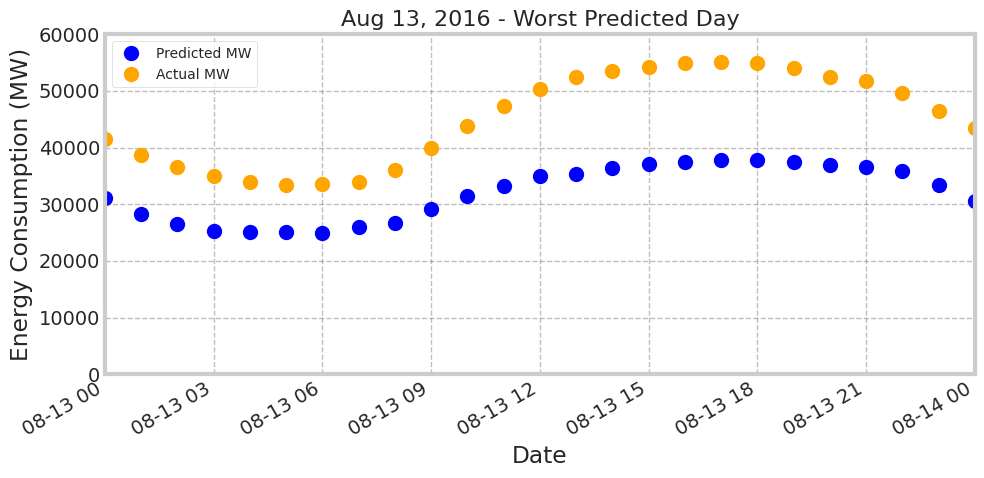

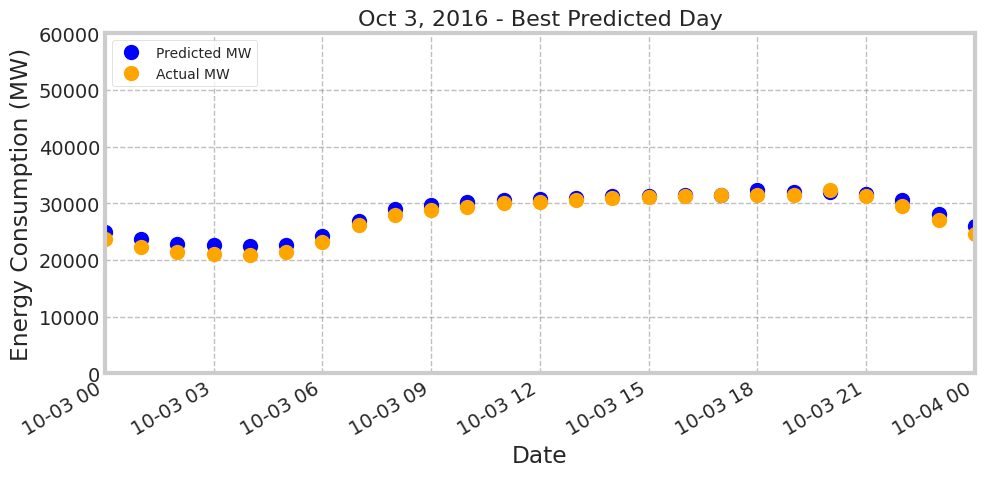

In [19]:
# Plot function for selected days with larger dots
def plot_selected_day(data, start_date, end_date, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot predicted values as larger blue dots
    data['MW_Prediction'].plot(
        ax=ax, 
        color='blue', 
        linestyle='',  # No connecting lines
        marker='o',    # Dots for points
        markersize=10, # Larger markers
        label='Predicted MW'
    )
    
    # Plot actual values as larger orange dots
    data['PJME_MW'].plot(
        ax=ax, 
        color='orange', 
        linestyle='',  # No connecting lines
        marker='o',    # Dots for points
        markersize=10, # Larger markers
        label='Actual MW'
    )
    
    # Set axis limits and labels
    ax.set_ylim(0, 60000)
    ax.set_xbound(lower=start_date, upper=end_date)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Date")
    ax.set_ylabel("Energy Consumption (MW)")
    ax.legend(loc="upper left", frameon=True, fontsize=10)
    
    # Enable grid for readability
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)
    
    plt.show()

# Plot worst predicted day (e.g., August 13, 2016)
plot_selected_day(pjme_all, '2016-08-13', '2016-08-14', "Aug 13, 2016 - Worst Predicted Day")

# Plot best predicted day (e.g., October 3, 2016)
plot_selected_day(pjme_all, '2016-10-03', '2016-10-04', "Oct 3, 2016 - Best Predicted Day")


## What's Next: Potential Improvements for the Model

While our current model provides a reasonably accurate forecast of energy consumption, there are several ways we can further refine and improve its performance:

1. **Add Holiday and Event Indicators**:
   - Our analysis shows that certain days, such as holidays, are challenging for the model to predict accurately. By adding features that indicate holidays or major events, we can help the model account for variations in energy consumption patterns during these periods.

2. **Incorporate Weather Data**:
   - Weather conditions like temperature, humidity, and wind speed significantly impact energy consumption. Integrating historical weather data for each timestamp may provide the model with valuable context, improving its ability to forecast accurately, particularly for extreme weather days.

3. **Experiment with Different Time Series Models**:
   - While XGBoost is effective for structured data, experimenting with time series-specific models such as ARIMA, SARIMA, Prophet, or even Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models may yield better results. These models are designed to capture temporal dependencies and seasonality, which are crucial in time series forecasting.

4. **Hyperparameter Tuning with More Trials**:
   - We conducted a limited number of Optuna trials for hyperparameter tuning. Increasing the number of trials may lead to discovering a better configuration of hyperparameters, further improving the model's accuracy.

5. **Explore Ensemble Techniques**:
   - Combining the predictions of multiple models (e.g., an ensemble of XGBoost with other machine learning models) can often improve forecast accuracy. Techniques like stacking, bagging, or blending may help reduce prediction errors.

6. **Use Feature Engineering for Cyclic Patterns**:
   - Energy consumption typically follows daily and weekly cycles. We've included basic cyclic features like hour and day of the week, but we could consider more advanced transformations, such as Fourier transformations, to better capture these cyclic patterns.

7. **Increase Data Quality and Quantity**:
   - If more historical data is available, adding it to the dataset could enhance the model's training and ability to generalize. Additionally, cleaning any anomalies or missing values in the data may reduce noise and improve model accuracy.

8. **Apply Cross-Validation for Time Series**:
   - To better evaluate the model's performance, we could implement time series cross-validation, such as walk-forward validation. This approach simulates real-world forecasting by training and testing the model on sequential folds of data, providing a more robust measure of its predictive ability.

## Conclusion
By applying these strategies, we can continue refining our model and potentially achieve even higher accuracy in forecasting energy consumption. Each of these steps presents an opportunity to dive deeper into the data, enhance model complexity where appropriate, and ultimately improve predictive performance for practical applications.
